# Neighborhood analysis 

In [2]:
import pickle
import sys, os
sys.path.append("/Users/chilpert/Work/pyproteinsExt/src")
sys.path.append("/Users/chilpert/Work/pyproteins/src")
import pyproteinsExt 
import pyproteins
import time
import subprocess
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

In [3]:
def save(data, tag=None):
    saveDir="/Volumes/arwen/mobi/group/NOX_CH/pickle_saved"
    timestr = time.strftime("%Y%m%d-%H%M%S")
    fTag = "NOX_annotation_" + tag + "_" if tag else "NOX_annotation_"
    fSerialDump = fTag + timestr + ".pickle"
    with open(saveDir + '/' + fSerialDump, 'wb') as f:
        pickle.dump(data, f)
    print('data structure saved to', saveDir + '/' + fSerialDump)

def load(fileName):
    saveDir="/Volumes/arwen/mobi/group/NOX_CH/pickle_saved"
    d = pickle.load( open(saveDir + "/" + fileName, "rb" ) )
    print("restore a annotated container of ", len(d), "elements")
    return d

### Load data

In [56]:
data=load("NOX_annotation_fullPfam_filteredDomains_20190509-124507.pickle")

restore a annotated container of  785 elements


### Compute neighborhood for genomes with RefSeq entry

In [64]:
import pyproteinsExt.refseq as refseq
refseqColl=refseq.getRefseqCollection()
refseqColl.setCache(location="/Users/chilpert/cache/refseq")
notBrowsed={}

count_refseq=0
count_protein_found=0
count_refseq_no_features=0
for p in data : 
    if data[p]['RefSeq']['genome']:
        data[p]['RefSeq']['neighborhood']={}
        count_refseq+=1
        obj=refseqColl.get(data[p]['RefSeq']['genome'][0])
        protein_feature=obj.searchCDS(data[p]['RefSeq']['protein'][0])
        if protein_feature: 
            count_protein_found+=1
            data[p]['RefSeq']['protein_feature']=protein_feature
            obj.getNeighborhood(protein_feature,10000)
            for n in obj.neighborhood: 
                name=n.qualifiers.get("protein_id","unknown")
                data[p]['RefSeq']['neighborhood'][n]={'cluster':None,'name':name}       
print(str(count_refseq)+" out of "+str(len(data))+ " proteins have RefSeq ID for the associated genome.")
print("We retrieve proteins from RefSeq annotation for "+str(count_protein_found)+" proteins.")
print(str(count_refseq_no_features))

Changing cache location to /Users/chilpert/cache/refseq
Reindexing /Users/chilpert/cache/refseq
Acknowledged 1 entries (/Users/chilpert/cache/refseq)
NEIGHBORHOOD
LIMITS 1315 None 22646 None
got to fetch NC_007760.1
Protein not found
got to fetch NZ_AMRN01000002.1
NEIGHBORHOOD
LIMITS 27896 None 49242 None
got to fetch NC_004605.1
Protein not found
got to fetch NZ_MWWX01000001.1
NEIGHBORHOOD
LIMITS 31066 None 52355 None
got to fetch NZ_MBSQ01000048.1
NEIGHBORHOOD
LIMITS 30676 None 51935 None
got to fetch NZ_KB933398.1
Protein not found
got to fetch NZ_LMJJ01000044.1
NEIGHBORHOOD
LIMITS 110979 None 132238 None
got to fetch NC_021191.1
Protein not found
got to fetch NZ_UHEW01000004.1
NEIGHBORHOOD
LIMITS 47886 None 69145 None
got to fetch NZ_UHEY01000001.1
Protein not found
got to fetch NZ_LN554847.1
Protein not found
got to fetch NZ_MTQP01000047.1
NEIGHBORHOOD
LIMITS 65732 None 87048 None
got to fetch NZ_MTQP01000051.1
NEIGHBORHOOD
LIMITS 78297 None 99613 None
got to fetch NZ_CP003987.1
P

NEIGHBORHOOD
LIMITS 152738 None 174081 None
got to fetch NZ_KI271351.1
NEIGHBORHOOD
LIMITS 49353 None 70549 None
got to fetch NZ_JWJD01000008.1
NEIGHBORHOOD
LIMITS 80281 None 101597 None
got to fetch NC_011751.1
Protein not found
got to fetch NC_004116.1
Protein not found
got to fetch NZ_LGKG01000101.1
NEIGHBORHOOD
LIMITS 129048 None 150415 None
got to fetch NZ_AP012547.1
Protein not found
got to fetch NC_006300.1
Protein not found
got to fetch NZ_LGDR01000262.1
NEIGHBORHOOD
LIMITS 106540 None 127835 None
got to fetch NZ_JAJC01000020.1
NEIGHBORHOOD
LIMITS 41205 None 62521 None
got to fetch NZ_LRXQ01000033.1
NEIGHBORHOOD
LIMITS 16880 None 38205 None
got to fetch NZ_KV766182.1
Protein not found
got to fetch NZ_CP011533.1
Protein not found
got to fetch NZ_CP016490.1
Protein not found
got to fetch NZ_LBGP01000005.1
NEIGHBORHOOD
LIMITS 195352 None 216683 None
got to fetch NZ_FMCT01000002.1
NEIGHBORHOOD
LIMITS 161866 None 183209 None
got to fetch NC_007925.1
Protein not found
got to fetch NZ

In [65]:
save(data,"withNeighborhood")

data structure saved to /Volumes/arwen/mobi/group/NOX_CH/pickle_saved/NOX_annotation_withNeighborhood_20190513-153603.pickle


In [67]:
data=load("NOX_annotation_withNeighborhood_20190513-153603.pickle")

restore a annotated container of  785 elements


In [68]:
c=0
fasta_out=open("/Volumes/arwen/mobi/group/NOX_CH/Neighborhood/uniprot_refseq_neighborhood.fasta","w")
c_neighbors=0
for p in data : 
    if data[p]['RefSeq'].get("neighborhood",None):
        #print(p)
        #print("PROTEIN",data[p]['RefSeq']['protein_feature'].qualifiers.get("protein_id",None),data[p]['RefSeq']['protein_feature'].qualifiers.get("product",None))
        for feature in data[p]['RefSeq']['neighborhood']: 
            id=feature.qualifiers.get("protein_id",None)
            name=feature.qualifiers.get("product",None)
            seq=feature.qualifiers.get("translation",None)
            if id : 
                c_neighbors+=1
                fasta_out.write(">"+p+"+"+id+" "+name+"\n"+seq+"\n")
        c+=1
fasta_out.close()        
print(str(c)+" proteins with neighborhood found from Uniprot entry (with RefSeq reference).")
print(str(c_neighbors)+" neigbors proteins found.")

139 proteins with neighborhood found from Uniprot entry (with RefSeq reference).
2383 neigbors proteins found.


#### Cluster neighborhood proteins with mmseqs2 default 80% threshold

```console 
WORKDIR=/Volumes/arwen/mobi/group/NOX_CH/Neighborhood

mmseqs createdb $WORKDIR/uniprot_refseq_neighborhood.fasta $WORKDIR/uniprot_refseq_neighborhood.mmseqsdb

mmseqs cluster $WORKDIR/uniprot_refseq_neighborhood.mmseqsdb $WORKDIR/uniprot_refseq_neighborhood_cluster80 $WORKDIR/tmp_uniprot_refseq_neighborhood_cluster80

mmseqs createtsv $WORKDIR/uniprot_refseq_neighborhood.mmseqsdb $WORKDIR/uniprot_refseq_neighborhood.mmseqsdb $WORKDIR/uniprot_refseq_neighborhood_cluster80 $WORKDIR/uniprot_refseq_neighborhood_cluster80.tsv --full-header
```

#### Treat clustering results

In [69]:
f=open("/Volumes/arwen/mobi/group/NOX_CH/Neighborhood/uniprot_refseq_neighborhood_cluster80.tsv","r")
dic_cluster={}
cluster_nb=0
browse_representative=set()
c=0
for l in f :
    c+=1
    l_split=l.rstrip().split("\t")
    representative=l_split[0].split(" ")[0].strip('"')
    seq=l_split[1].split(" ")[0].strip('"')
    protein=seq.split("+")[1]
    seq_desc=" ".join(l_split[1].split(" ")[1:]).rstrip(" ").strip('"')
    nox_all=seq.split("+")[0]
    nox=seq.split("+")[0].split("|")[1]
    if representative not in browse_representative: 
        cluster_nb+=1
        dic_cluster[cluster_nb]={}
        browse_representative.add(representative)  
    if nox_all not in dic_cluster[cluster_nb]:
        dic_cluster[cluster_nb][nox_all]={}
        dic_cluster[cluster_nb][nox_all]['seqs']=set()
        dic_cluster[cluster_nb][nox_all]['descs']=set()
    dic_cluster[cluster_nb][nox_all]['seqs'].add(seq)
    dic_cluster[cluster_nb][nox_all]['descs'].add(seq_desc)
f.close()
print(str(len(dic_cluster))+" clusters have been created.")

1191 clusters have been created.


#### Complete data container

In [96]:
for c in dic_cluster:
    for nox in dic_cluster[c]:
        for p in dic_cluster[c][nox]['seqs']:
            protein_name=p.split("+")[1]
            feature=[f for f in data[nox]['RefSeq']['neighborhood'] if data[nox]['RefSeq']['neighborhood'][f]['name']==protein_name][0]
            data[nox]['RefSeq']["neighborhood"][feature]["cluster"]=c
            

In [98]:
save(data,"withCompleteNeighborhood")

data structure saved to /Volumes/arwen/mobi/group/NOX_CH/pickle_saved/NOX_annotation_withCompleteNeighborhood_20190513-154512.pickle


In [4]:
data=load("NOX_annotation_withCompleteNeighborhood_20190513-154512.pickle")

restore a annotated container of  785 elements


* Verify if we have 2 proteins in same neighborhood in one cluster

In [33]:
c_single=0
c_just_same_neighborhood=0
c_no_single=0
c_same_neighborhood=0
unique=0
o=open("/Volumes/arwen/mobi/group/NOX_CH/Neighborhood/clusters_description.tsv","w")
o2=open("/Volumes/arwen/mobi/group/NOX_CH/Neighborhood/clusters_description_same_neighborhood.tsv","w")
o.write("#cluster\tnb_proteins\tnb_neighborhood\tnox_seeds\tlist_protein\ttype\trepetitions\tdescription\n")
#o2.write("#cluster\tnb_total_proteins\tnb_concern_proteins\tall_nox\tnox_with_repetition:nb_repetition\tcluster_description\n")
for c in dic_cluster: 
    repetition_str="NA"
    proteins=set()
    descs=set()
    nox=list(dic_cluster[c].keys())
    nox_simple=[n.split("|")[1] for n in nox]
    for p in [dic_cluster[c][nox]['seqs'] for nox in dic_cluster[c]]:
        proteins.update(p)
    for d in [dic_cluster[c][nox]['descs'] for nox in dic_cluster[c]]:
        descs.update(d)      
    if len(proteins)>1 : 
        c_no_single+=1
        if len(proteins)==len(nox):
            unique+=1
            type="unique_in_neighborhoods"
        else: 
            concern_proteins=set()
            repetition_str=""
            for n in nox:
                if len(dic_cluster[c][n]["seqs"])>1:
                    concern_proteins.update(dic_cluster[c][n]["seqs"])
                    repetition_str+=n.split("|")[1]+":"+str(len(dic_cluster[c][n]["seqs"]))+","
    
            repetition_str=repetition_str.rstrip(",")
            if len(nox)==1: 
                c_just_same_neighborhood+=1
                type="just_same_neighborhood"
            else: 
                c_same_neighborhood+=1
                type="same_neighborhood"
    else: 
        c_single+=1
        type="singleton"
    o.write(str(c)+"\t"+str(len(proteins))+"\t"+str(len(nox))+"\t"+",".join(proteins)+"\t"+",".join(nox_simple)+"\t"+type+"\t"+repetition_str+"\t"+",".join(descs)+"\n")
o.close()
#o2.close()
print("Singletons :", c_single)
print("Repetition just in same neighborhood :",c_just_same_neighborhood)
print("Several neighborhood :",c_no_single)
print("Several neighborhood and repetition in at least one :", c_same_neighborhood)

Singletons : 844
Repetition just in same neighborhood : 14
Several neighborhood : 347
Several neighborhood and repetition in at least one : 13


-- Clusters in 1 neighborhood
844 Unique
14 Repetition
-- Clusters in > 1 neighborhood
320 Unique
13 Repetition


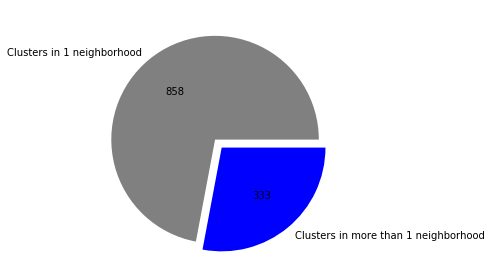

In [34]:
labels='Clusters in 1 neighborhood','Clusters in more than 1 neighborhood'
one_neighborhood=[c for c in dic_cluster if len(dic_cluster[c])==1]
several_neighborhood=[c for c in dic_cluster if len(dic_cluster[c])>1]
size=[len(one_neighborhood),len(several_neighborhood)]
explode=(0,0.1)
colors=['grey','blue']
plt.pie(size,labels=labels,explode=explode,colors=colors,autopct=lambda p: '{:.0f}'.format(p * len(dic_cluster) / 100))
plt.tight_layout()
plt.savefig("/Users/chilpert/Work/NOX_visu/clusters_size.pdf", bbox_inches='tight',format="pdf")

one_unique=0
one_rep=0
for c in one_neighborhood : 
    for nox in dic_cluster[c]:
        if len(dic_cluster[c][nox]["seqs"])>1: 
            one_rep+=1
        else:
            one_unique+=1

several_unique=0
several_rep=0 
for c in several_neighborhood: 
    unique=True
    for nox in dic_cluster[c]:
        if len(dic_cluster[c][nox]["seqs"]) > 1: 
            unique=False
    if unique: 
        several_unique+=1
    else:
        several_rep+=1
            
print("-- Clusters in 1 neighborhood")
print(one_unique,"Unique")
print(one_rep,"Repetition")
print("-- Clusters in > 1 neighborhood")
print(several_unique,"Unique")
print(several_rep,"Repetition")

In [35]:
dic_nb_neighborhood={}
for c in several_neighborhood: 
    nb_neighborhood=len(dic_cluster[c].keys())
    if nb_neighborhood not in dic_nb_neighborhood: 
        dic_nb_neighborhood[nb_neighborhood]=0 
    dic_nb_neighborhood[nb_neighborhood]+=1    

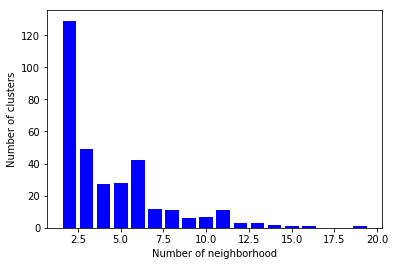

In [36]:
import matplotlib.pyplot as plt
x=dic_nb_neighborhood.keys()
y=dic_nb_neighborhood.values()
plt.bar(x,y,color="blue")
plt.ylabel("Number of clusters")
plt.xlabel("Number of neighborhood")
plt.savefig("/Users/chilpert/Work/NOX_visu/neighborhood_distrib_cluster.pdf",format="pdf")

* Write proteins stats

In [37]:
invert_dic_cluster={}
for c in dic_cluster :
    for nox in dic_cluster[c]:
        if nox not in invert_dic_cluster : 
            invert_dic_cluster[nox]={}
        neighbors=dic_cluster[c][nox]['seqs']
        for n in neighbors: 
            invert_dic_cluster[nox][n]={}
            invert_dic_cluster[nox][n]['cluster']=c
            invert_dic_cluster[nox][n]['desc']=dic_cluster[c][nox]['descs']

In [38]:
proteins_stats=open("/Volumes/arwen/mobi/group/NOX_CH/Neighborhood/proteins_neighbors_stats.tsv","w")
proteins_stats.write("#Protein\tNumber of neighbors\tList of neighbors number\tList of neighbors id\tList of neighbors description\n")

for p in invert_dic_cluster: 
    neighbors_cluster=[str(invert_dic_cluster[p][n]['cluster']) for n in invert_dic_cluster[p]]
    neighbors_id=[n.split("+")[1] for n in invert_dic_cluster[p]]
    neighbors_desc=""
    for d in [invert_dic_cluster[p][n]['desc'] for n in invert_dic_cluster[p]]:
        for d2 in d : 
            neighbors_desc+=d2.rstrip()+","
        neighbors_desc=neighbors_desc.rstrip(",")+";"      
    neighbors_desc=neighbors_desc.rstrip(";")    
    proteins_stats.write(p+"\t"+str(len(invert_dic_cluster[p]))+"\t"+",".join(neighbors_cluster)+"\t"+",".join(neighbors_id)+"\t"+neighbors_desc+"\n")
proteins_stats.close()

* Assemble clusters to contains same nox protein

In [39]:
def assemble_neighbors_with_same_proteins(dic_cluster):
    intermediate_dic={}
    for c in dic_cluster:
        noxs=list(dic_cluster[c].keys())
        noxs.sort()
        noxs=",".join(noxs)
        if not noxs in intermediate_dic: 
            intermediate_dic[noxs]=set()
        intermediate_dic[noxs].add(str(c))
    new_dic={}    
    for p in intermediate_dic: 
        clusts=",".join(intermediate_dic[p])
        new_dic[clusts]=p.split(",")
    return new_dic    

In [40]:
assemble_dic_neighbor=assemble_neighbors_with_same_proteins(dic_cluster)

* Sort by number of proteins and by number of neighbors

In [41]:
from collections import OrderedDict
ordered_dic_neighbor_by_prot=OrderedDict(sorted(assemble_dic_neighbor.items(),key=lambda kv: len(kv[1]),reverse=True))
ordered_dic_neighbor_by_neighbor=OrderedDict(sorted(assemble_dic_neighbor.items(),key=lambda kv: kv[0].count(","),reverse=True))

In [42]:
all_tree=load("NOX_annotation_Tree_20190510-103656.pickle")

restore a annotated container of  622 elements


In [43]:
from ete3 import NCBITaxa
ncbi = NCBITaxa()

In [44]:
from statistics import mean

def get_upper_node(taxids,all_tree):
    if len(taxids)==1: 
        return all_tree.search_nodes(name=taxids[0])[0]
    else:     
        tree=ncbi.get_topology(taxids)
        traverse_generator=tree.traverse()
        return next(traverse_generator)
    
def get_mean_distance(taxids,all_tree):
    dists=[]
    tree=ncbi.get_topology(taxids)
    if len(taxids)==1:
        return 0
    for i in range(len(taxids)): 
        for j in range(i+1,len(taxids)): 
            dist=tree.get_distance(taxids[i],taxids[j])
            dists.append(dist)
    return mean(dists)        

In [196]:
o=open("/Volumes/arwen/mobi/group/NOX_CH/Neighborhood/assemble_neigbors_stats.tsv","w")
o.write("#Neighbors group\tNumber of neighborhoods\tNeigborhoods\tNeighbors description\tUpper node(taxid)\tUpper node(name)\tUpper node (rank)\tMean distance\n")
for c in ordered_dic_neighbor_by_prot: 
    neighborhoods=set(ordered_dic_neighbor_by_prot[c])
    neighborhoods_simple=[n.split('|')[1] for n in neighborhoods]
    clusters_desc=""
    for sub_c in c.split(","):
        descs=",".join(set([d.rstrip() for n in dic_cluster[int(sub_c)] for d in dic_cluster[int(sub_c)][n]['descs']]))
        clusters_desc+=descs+";"     
    clusters_desc=clusters_desc.rstrip(";")
    taxids=list(set([data[n]['taxid'] for n in neighborhoods]))
    upper_node=get_upper_node(taxids,all_tree)
    mean_distance=get_mean_distance(taxids,all_tree)
    o.write(c+"\t"+str(len(neighborhoods))+"\t"+",".join(neighborhoods_simple)+"\t"+clusters_desc+"\t"+upper_node.name+"\t"+upper_node.sci_name+"\t"+upper_node.rank+"\t"+str(mean_distance)+"\n")
o.close()    

In [164]:
dic_coocurrent_number={}
for c in ordered_dic_neighbor_by_prot: 
    if len(ordered_dic_neighbor_by_prot[c])>1 : 
        nb_coocurrent=c.count(",")+1
        if nb_coocurrent not in dic_coocurrent_number: 
            dic_coocurrent_number[nb_coocurrent]=0
        dic_coocurrent_number[nb_coocurrent]+=1    

In [165]:
print(dic_coocurrent_number)

{1: 109, 3: 3, 7: 2, 4: 4, 2: 22, 11: 2, 10: 3, 9: 2, 5: 3, 8: 1, 6: 3, 18: 1, 12: 1}


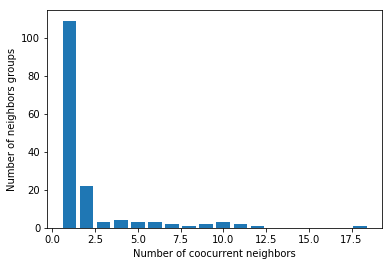

In [203]:
x=dic_coocurrent_number.keys()
y=dic_coocurrent_number.values()
plt.bar(x,y)
plt.xlabel("Number of coocurrent neighbors")
plt.ylabel("Number of neighbors groups")
plt.savefig("/Users/chilpert/Work/NOX_visu/coocurrent_neighbors.pdf",format="pdf")

#### Distribution of neighbors size

In [350]:
dic_nb_proteins={}
list_nb_proteins=[]
for p in all_refseq_proteins: 
    neighborhood=data[p]['RefSeq']['neighborhood']
    proteins=[f for f in data[p]['RefSeq']['neighborhood'] if data[p]['RefSeq']['neighborhood'][f]['name']!="unknown"]
    list_nb_proteins.append(len(proteins))
    if len(proteins) not in dic_nb_proteins: 
        dic_nb_proteins[len(proteins)]=0
    dic_nb_proteins[len(proteins)]+=1    

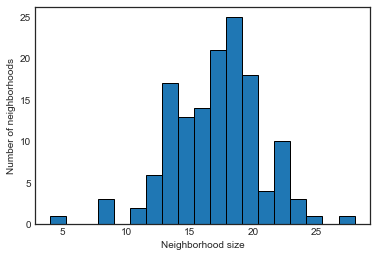

In [363]:
plt.style.use('seaborn-white')
plt.hist(list_nb_proteins,bins=len(set(list_nb_proteins)),edgecolor="black")
plt.xlabel("Neighborhood size")
plt.ylabel("Number of neighborhoods")
plt.savefig("/Users/chilpert/Work/NOX_visu/distribution_neighborhoods_size.pdf")

### Distance matrix between neighborhood 

#### Complete data container

In [5]:
all_refseq_proteins=[p for p in data if data[p]['RefSeq'].get("neighborhood",None)]

In [23]:
common_neighbors_matrix=[[None]*len(all_refseq_proteins)for i in range(len(all_refseq_proteins))]
presence_absence_matrix=[[0]*len(all_refseq_proteins)for i in range(len(all_refseq_proteins))]
mask=[[1]*len(all_refseq_proteins)for i in range(len(all_refseq_proteins))]
for i in range(len(all_refseq_proteins)): 
    prot1=all_refseq_proteins[i]
    clusters1=[data[prot1]['RefSeq']['neighborhood'][f]['cluster'] for f in data[prot1]['RefSeq']['neighborhood']]
    common_neighbors_matrix[i][i]=len(clusters1)
    for j in range(i+1, len(all_refseq_proteins)):
        prot2=all_refseq_proteins[j]
        clusters2=[data[prot2]['RefSeq']['neighborhood'][f]['cluster'] for f in data[prot2]['RefSeq']['neighborhood']]
        intersect=set(clusters1).intersection(set(clusters2))
        common_neighbors_matrix[i][j]=len(intersect)
        common_neighbors_matrix[j][i]=len(intersect)
        if len(intersect)>=20: 
            presence_absence_matrix[i][j]=1
        mask[i][j]=0

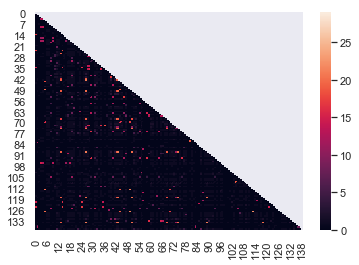

In [15]:
import seaborn as sns 
import numpy as np
sns.set(font_scale=1)
sns.heatmap(common_neighbors_matrix,mask=mask).figure.savefig("/Users/chilpert/Work/NOX_visu/neighorhoods_heatmap.pdf")

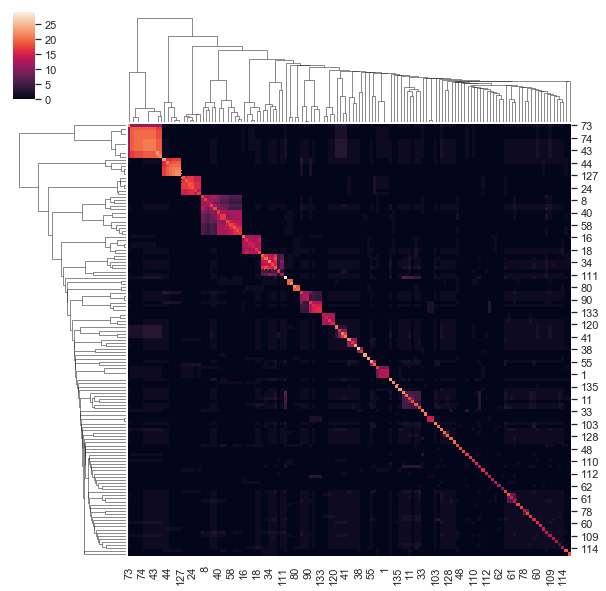

In [16]:
sns.clustermap(common_neighbors_matrix)

In [19]:
from igraph import *

In [24]:
g=Graph.Adjacency(presence_absence_matrix,mode=ADJ_MAX)

In [25]:
for v in g.vs: 
    v['name']=all_refseq_proteins[v.index].split("|")[1]
    v["label"]=v["name"]

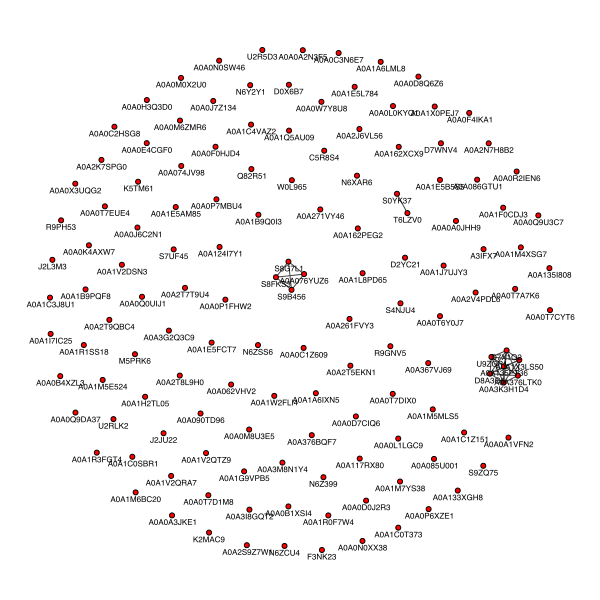

In [26]:
plot(g,vertex_size=5,edge_size=1,vertex_label_size=8,vertex_label_dist=1.5,target="/Users/chilpert/Work/NOX_visu/neighborhoods10_graphs.pdf",margin=50)

In [30]:
connected_comp=g.clusters()
nb_cc=0
for cc in connected_comp.subgraphs(): 
    if len(cc.vs)>1: 
        nb_cc+=1
        plot(cc,vertex_label_dist=1.5,vertex_label_size=20,edge_label_dist=0,edge_color="grey",target="/Users/chilpert/Work/NOX_visu/neighborhoods20/"+str(nb_cc)+".pdf",margin=100)